## Importing Libraries and Modules

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from PIL import Image
from tensorflow.python import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, Conv2D, Dropout
from mtcnn import MTCNN

Using TensorFlow backend.


## Visualisation of Different Images in the Dataset

In [2]:
def plot_portraits(images, titles, h, w, n_row, n_col):
    plt.figure(figsize=(2.2 * n_col, 2.2 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.20)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i], cmap=plt.cm.gray)
        plt.title(titles[i])
        plt.xticks(())
        plt.yticks(())

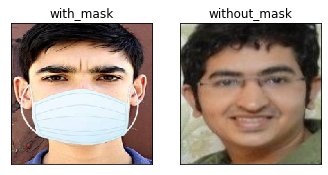

In [3]:
dir = 'preprocessed_haar/'
folders = os.listdir(dir)
photos = [dir + '/' + folder for folder in folders]

all_images = []
for i in range(len(photos)):
    all_images.append(os.listdir(photos[i])[0])

images = []
for i in range(len(photos)):
    images.append(photos[i] + "/" + all_images[i])
    
images = np.array([cv2.imread(image)[...,::-1] for image in images])
names = [name[2:] for name in folders]
plot_portraits(images, names, 256, 256, n_row=1, n_col=2)

## Reading and Preparing Data

In [4]:
def prepare_data(path):
    X = []
    y = []
    for folder in os.listdir(path):
        for file in os.listdir(path + folder):
            image = cv2.imread(os.path.join(path + folder, file))
            image = cv2.resize(image, (256,256), interpolation = cv2.INTER_AREA)
            X.append(image)
            y.append(int(folder[0]))
        
    X = np.array(X)
    X = X/255
    y = to_categorical(y, num_classes=2)
    
    return X, y

## Model Building

In [5]:
model = keras.models.Sequential()

model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(256, 256, 3)))
model.add(Conv2D(20, kernel_size=3, activation='relu'))       
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='softmax'))  #2 classes 

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 252, 252, 20)      5780      
_________________________________________________________________
flatten (Flatten)            (None, 1270080)           0         
_________________________________________________________________
dense (Dense)                (None, 128)               162570368 
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 162,577,302
Trainable params: 162,577,302
Non-trainable params: 0
_________________________________________________________________
None


## Model Training

In [6]:
DATASET_PATH = "preprocessed_haar/"
X, y = prepare_data(DATASET_PATH)
print("Size of dataset: " + str(len(X)) + " images")

Size of dataset: 917 images


In [7]:
model.fit(X, y, epochs=2, validation_split=0.2)

Train on 733 samples, validate on 184 samples
Epoch 1/2
733/733 [==============================] - 76s 104ms/sample - loss: 20.2574 - accuracy: 0.8022 - val_loss: 0.1165 - val_accuracy: 0.9837
Epoch 2/2
733/733 [==============================] - 72s 98ms/sample - loss: 0.1828 - accuracy: 0.9577 - val_loss: 0.0857 - val_accuracy: 0.9728


## Model Testing

In [8]:
labels_dict={0:'without_mask', 1:'with_mask'}
color_dict={0:(0,0,255), 1:(0,255,0)}
detector = MTCNN()

In [9]:
def show_result(image):
    im = cv2.imread(image)
    faces = detector.detect_faces(im)
    
    for face in faces:
        x, y, w, h = face['box']
        offset=10
        face_img = im[int(y-min(y, offset)):int(y+h+offset), int(x-min(x, offset)):int(x+w+offset)]

        resized=cv2.resize(face_img,(256,256))
        normalized=resized/255.0
        reshaped=np.reshape(normalized,(1,256,256,3))
        reshaped = np.vstack([reshaped])
        result=model.predict(reshaped)
        label=np.argmax(result,axis=1)[0]

        cv2.rectangle(im,(x,y),(x+w,y+h),color_dict[label],2)
        cv2.rectangle(im,(x,y-40),(x+w,y),color_dict[label],-1)
        cv2.putText(im, labels_dict[label], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),3)

    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
    plt.title(image[12:])
    plt.show()
    return

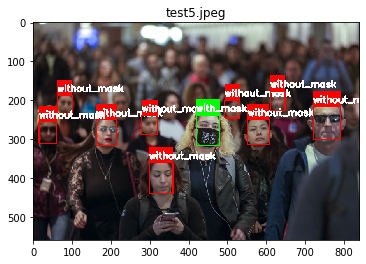

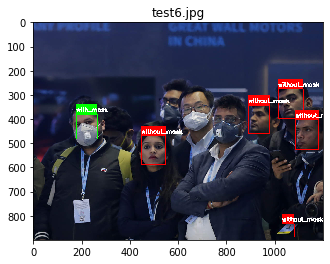

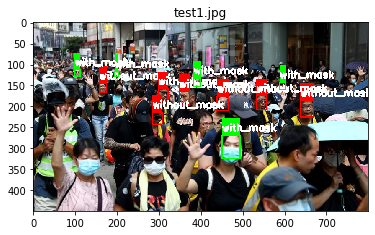

[None, None, None]

In [11]:
images = ["Test-Images/test5.jpeg", "Test-Images/test6.jpg", "Test-Images/test1.jpg"]
[show_result(img) for img in images]